## Supervised Learning 2: Multiple Regression and Classification

### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
import math

In the previous lecture, we introduced linear regression with a practical example focused on predicting house prices based on a single feature (house area). Now, let’s expand this approach by incorporating multiple features to make more accurate house price predictions.

## Table of Contents

1. [Data Loading and Inspection](#data-loading)
2. [Data Vizualization](#data-visualization)
3. [Multiple Linear Regression Definition](#multiple-regression-definition)
    1. [Cost Function](#cost-function)
    2. [Gradient Descent Algorithm](#gradient-descent-algorithm)
4. [Data Transformation and Engineering](#data-transformation)
5. [Training Model](#training-model)
6. [Scikit-learn Library for Linear Regression](#sklearn)
7. [Classification](#classification)

## Data Loading and Inspection <a id="data-loading">

While the dataset in the previous lecture was synthetically generated to demonstrate the basics of linear regression, in this lecture, we’ll work with a real-world dataset containing over 1,000 house prices from the USA. 

Below you can find a brief description of it's columns:
- OverallQual: Overall material and finish quality
- GrLivArea: Above ground living area in square feet
- BedroomAbgGr: Bedrooms above ground (does NOT include basement bedrooms)
- GarageArea: Size of garage in square feet
- YearBuilt: Original construction year
- KitchenQual: Kitchen quality
- SalePrice: the property's sale price in dollars. This is the target variable that we're trying to predict.


In [3]:
df = pd.read_csv('data/house_prices_multiple_features.csv')

In [4]:
df.describe()

,OverallQual,GrLivArea,BedroomAbvGr,GarageArea,YearBuilt,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,1515.463699,2.866438,472.980137,1971.267808,180921.195890
std,1.382997,525.480383,0.815778,213.804841,30.202904,79442.502883
min,1.000000,334.000000,0.000000,0.000000,1872.000000,34900.000000
25%,5.000000,1129.500000,2.000000,334.500000,1954.000000,129975.000000
50%,6.000000,1464.000000,3.000000,480.000000,1973.000000,163000.000000
75%,7.000000,1776.750000,3.000000,576.000000,2000.000000,214000.000000
max,10.000000,5642.000000,8.000000,1418.000000,2010.000000,755000.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   OverallQual   1460 non-null   int64 
 1   GrLivArea     1460 non-null   int64 
 2   BedroomAbvGr  1460 non-null   int64 
 3   GarageArea    1460 non-null   int64 
 4   YearBuilt     1460 non-null   int64 
 5   KitchenQual   1460 non-null   object
 6   SalePrice     1460 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 80.0+ KB


**Observation**: The dataset contains 1,460 rows, and there are no missing values. The `KitchenQual` column is categorical.

## Data Visualization<a id="data-visualization">

Let's start with the visualization of the relationship between GrLivArea and SalePrice.

Text(0, 0.5, 'SalePrice')

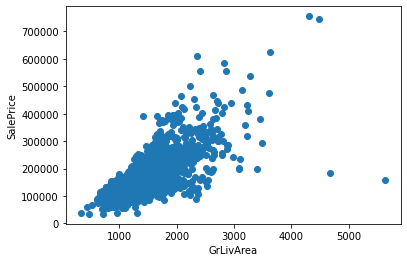

In [6]:
plt.scatter(df['GrLivArea'], df['SalePrice'])

plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")

It can be seen that as house area increase, the sale price also becomes higher. Next, let's see the relationship between GarageArea and SalePrice.

Text(0, 0.5, 'SalePrice')

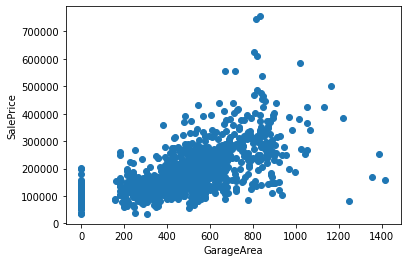

In [7]:
plt.scatter(df['GarageArea'], df['SalePrice'])

plt.xlabel("GarageArea")
plt.ylabel("SalePrice")

Although on average SalePrice tends to increase with higher GarageArea, the linear relationship is not that strong as between GrLivArea and SalePrice.

Next, let's visualize the relationship between YearBuilt and SalePrice.

Text(0, 0.5, 'SalePrice')

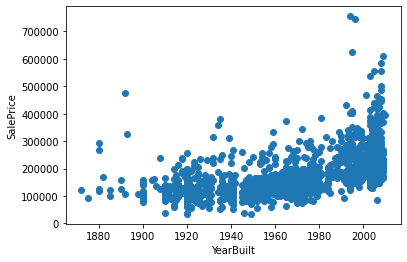

In [8]:
plt.scatter(df['YearBuilt'], df['SalePrice'])

plt.xlabel("YearBuilt")
plt.ylabel("SalePrice")

The scatter plot shows that newer houses tend to have higher sale prices, but the relationship isn't strictly linear. There's more variability in prices for newer houses, indicating other factors may influence sale price, especially for recently built homes.

`OverallQual` is an ordinal variable, meaning it reflects a ranked level of overall house quality and it only takes on a predefined set of values.

To better understand the relationship between `OverallQual` and `SalePrice`, we can visualize this with a boxplot, which will show the distribution of sale prices across different overall quality levels. This will help us observe how the target variable (`SalePrice`) varies based on the ranked quality levels.

Let's plot the boxplot for `SalePrice` grouped by `OverallQual`.

*(A boxplot represents the distribution of data by showing the median, quartiles, and potential outliers, allowing us to easily compare the spread and central tendency across different groups)*

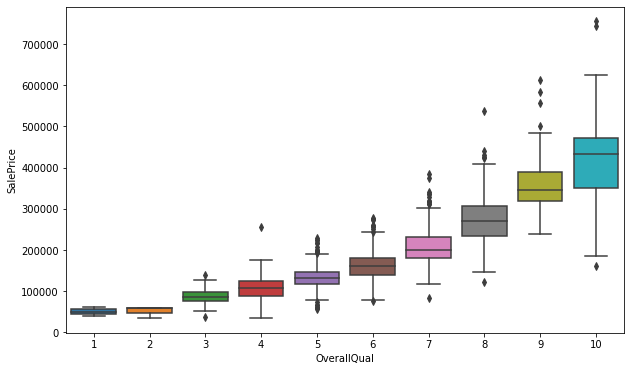

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

_ = sns.boxplot(data=df, x='OverallQual', y='SalePrice', ax=ax)

The boxplot clearly shows a positive relationship between `OverallQual` and `SalePrice`. As the `OverallQual` increases, the median `SalePrice` also increases significantly. 

Let's do know a similar boxplot for `BedroomAbvGr` features.

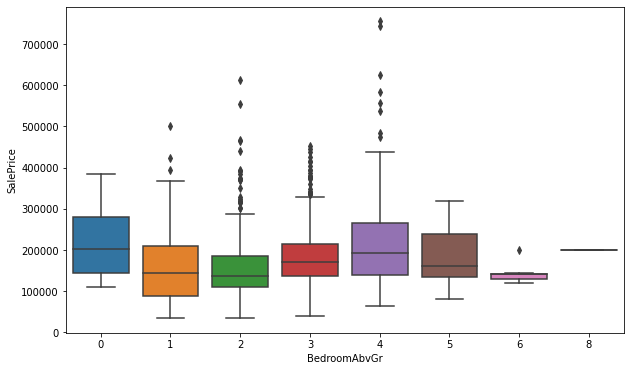

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

_ = sns.boxplot(data=df, x='BedroomAbvGr', y='SalePrice', ax=ax)

The relationship between BedroomAbgGr and SalePrice is not that evident. Let's inspect how much houses we have for each distinct BedroomAbvGr value.

In [11]:
df['BedroomAbvGr'].value_counts()

3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

The number of houses with `BedroomAbgGr` equal to 0, 5, 6 and 8 is considerably low, which makes it insufficient to estimate a reliable relationship between BedroomAbvGr and SalePrice for these values. As a result, any patterns observed for these categories may not be statistically significant and should be interpreted with caution.

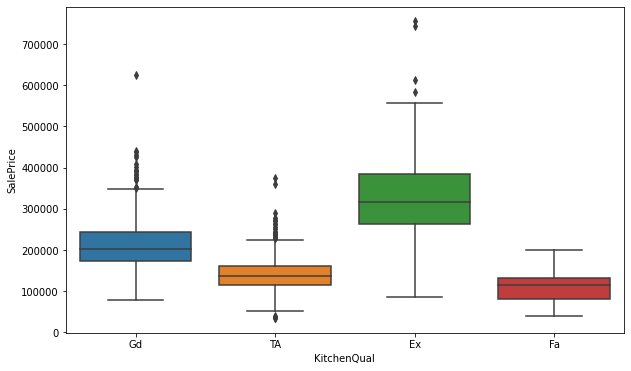

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

_ = sns.boxplot(data=df, x='KitchenQual', y='SalePrice', ax=ax)

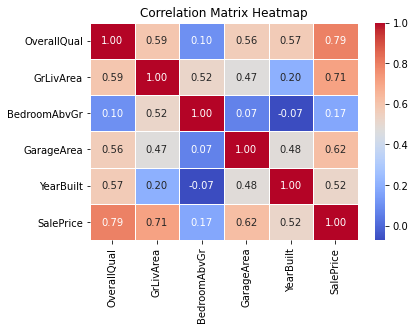

In [13]:
correlation_matrix = df.corr()


sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Display the heatmap
plt.title('Correlation Matrix Heatmap')
plt.show()

Once we understood our data, let's train a linear regression model on it to be able to make the predictions.

## Multiple Linear Regression Definition <a id="multiple-regression-definition">

The formula for regression with multiple variables can be expressed as:

$$
f_{w, b}(x) = w_0 x_0 + w_1 x_1 + \dots + w_{n-1} x_{n-1} + b
$$

Where:

- $f_{w, b}(x)$ is the predicted value
- $w_0, w_1, \dots, w_{n-1}$ are the weights (coefficients) for each feature $x_0, x_1, \dots, x_{n-1}$
- $b$ is the bias (intercept) term
- $x_0, x_1, \dots, x_{n-1}$ are the input features (variables).

The formula can be expressed in vector form as:

$$
f_{\mathbf{w}, b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b 
$$

Where:

- $\mathbf{x}$ is the feature vector of a given training example,
- $\mathbf{w}$ is the weight vector corresponding to the features.

The vectors are defined as:

$$
\mathbf{w} = \begin{bmatrix} w_0 & w_1 & w_2 & \dots & w_{n-1} \end{bmatrix}
$$
$$
\mathbf{x} = \begin{bmatrix} x_0 & x_1 & x_2 & \dots & x_{n-1} \end{bmatrix}
$$

In this form, $\mathbf{w} \cdot \mathbf{x}$ represents the dot product of the weight vector $\mathbf{w}$ and the feature vector $\mathbf{x}$.

Below you can find the implementation of `predict` function for multiple linear regression.

In [14]:
def predict(x, w, b):
    return np.dot(x, w) + b

### Cost Function for Multiple Variables Linear Regression<a id="cost-function">

The equation for the cost function for multiple variables linear regression is similar as in the single-variable case, the only difference lies in the prediction function, which now incorporates multiple features.


$$J(\mathbf{w}, b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} \left( f_{\mathbf{w}, b}(\mathbf{x}^{(i)}) - y^{(i)} \right)^2 $$

where:

$$f_{\mathbf{w}, b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot  \mathbf{x}^{(i)} + b $$

Here:
- $\mathbf{w} = [w_0, w_1, \dots, w_{n-1}]$ is the weight vector.
- $\mathbf{x}^{(i)} = [x_0^{(i)}, x_1^{(i)}, \dots, x_{n-1}^{(i)}]$ is the input feature vector for the $i$-th example.
- $y^{(i)}$ is the target value.
- $b$ is the bias term.
- $m$ is the number of training examples.

In [15]:
def compute_cost(X, y, w, b):
    """
    Computes the cost (mean squared error) for the linear regression model.

    Args:
        X (2D ndarray): Input data of shape (m, n), where m is the number of examples and n is the number of features.
        y (ndarray): Target values of shape (m,).
        w (ndarray): Model parameters (weights) of shape (n,).
        b (float): Model parameter (bias) scalar.

    Returns:
        float: The computed cost (mean squared error).
    """
    m = X.shape[0]
    cost = 0
    
    for i in range(m):
        prediction = np.dot(X[i], w) + b
        cost += (prediction - y[i])**2
    
    return cost / (2 * m)

### Gradient Descent for Multiple Variables Linear Regression<a id="gradient-descent-algorithm">

The gradient descent approach remains the same - we update each model parameter by subtracting the partial derivative of the cost function with respect to that parameter, scaled by the learning rate. This ensures the parameters move in the direction of the steepest descent, minimizing the cost function.


The update rule is:

$$
\begin{align*}
\text{Repeat:} \quad &\lbrace \\
w_j &= w_j - \alpha \frac{\partial J(\mathbf{w}, b)}{\partial w_j} \quad \text{for } j = 0, \dots, n-1 \\
b &= b - \alpha \frac{\partial J(\mathbf{w}, b)}{\partial b} \\
&\rbrace
\end{align*}
$$

where the partial derivatives are:

$$
\frac{\partial J(\mathbf{w}, b)}{\partial w_j} = \frac{1}{m} \sum_{i=0}^{m-1} \left(f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}\right) x_j^{(i)}
$$

$$
\frac{\partial J(\mathbf{w}, b)}{\partial b} = \frac{1}{m} \sum_{i=0}^{m-1} \left(f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}\right)
$$

In these equations:
- $\alpha$  is the learning rate,
- $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b$ is the prediction for the $i$-th training example,
- $y^{(i)}$ is the target value,
- $m$ is the number of training examples.

The `compute_gradient` function calculates the partial derivatives of the cost function with respect to the model parameters $w$ (weights) and $b$ (bias). The outer loop iterates over all $m$ training examples, while the inner loop iterates over each feature, accumulating the gradients for $w$ into the $dw$ vector and for $b$ into $db$. These accumulated values are averaged over the number of examples to compute the final gradients.



In [16]:
def compute_gradient(X, y, w, b):
    """
    Computes the gradient of the cost function with respect to model parameters w and b.

    Args:
        X (2D ndarray): Input data of shape (m, n), where m is the number of examples and n is the number of features.
        y (ndarray): Target values of shape (m,).
        w (ndarray): Model parameters (weights) of shape (n,).
        b (float): Model parameter (bias) scalar.

    Returns:
        tuple: Gradients of cost with respect to b (scalar) and w (ndarray of shape (n,)).
    """
    m, n = X.shape
    dw = np.zeros((n,))
    db = 0
    
    for i in range(m):
        prediction = np.dot(X[i], w) + b
        error = prediction - y[i]
        
        for j in range(n):
            dw[j] += error * X[i, j]
            
        db += error
    
    dw /= m
    db /= m
    
    return db, dw

The `gradient_descent` function iteratively optimizes the model parameters $w$ and $b$ by computing the gradients at each step and updating the parameters. The $dw$ returned by `compute_gradient` is a vector, and the entire $w$ vector is updated simultaneously using vectorized operations. This ensures efficient updates to all weights in one step. 



In [17]:
def gradient_descent(X, y, w_init, b_init, alpha, iterations):
    """
    Performs gradient descent to optimize model parameters w and b.

    Args:
        X (ndarray): Input data of shape (m, n), where m is the number of examples and n is the number of features.
        y (ndarray): Target values of shape (m,).
        w_init (ndarray): Initial values for the model parameters (weights) of shape (n,).
        b_init (float): Initial value for the model parameter (bias) scalar.
        alpha (float): Learning rate.
        iterations (int): Number of iterations to run gradient descent.

    Returns:
        tuple: Optimized model parameters w (ndarray of shape (n,)) and b (scalar).
    """
    w = w_init.copy()
    b = b_init
    J_hist = []
    for i in range(iterations):
        db, dw = compute_gradient(X, y, w, b)
        w -= alpha * dw
        b -= alpha * db
        
        curr_cost = compute_cost(X, y, w, b)
        J_hist.append(curr_cost)

        if i% math.ceil(iterations / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_hist[-1]:8.2f}   ")

    return w, b, J_hist

## Data Transformation & Engineering <a id="data-transformation">

Remember that we had one categorical column KitchenQual, let's encode it using ordinal encoding strategy.

In [18]:
kitchen_qual_mapping = {
    'Ex': 3,  # Excellent
    'Gd': 2,  # Good
    'TA': 1,  # Typical/Average
    'Fa': 0   # Fair
}

df.KitchenQual = df.KitchenQual.map(kitchen_qual_mapping)

In [19]:
df.head()

,OverallQual,GrLivArea,BedroomAbvGr,GarageArea,YearBuilt,KitchenQual,SalePrice
0,7,1710,3,548,2003,2,208500
1,6,1262,3,460,1976,1,181500
2,7,1786,3,608,2001,2,223500
3,7,1717,3,642,1915,2,140000
4,8,2198,4,836,2000,2,250000


Let's add new features to the dataset based on some intuitive assumptions:

In [20]:
# Create a binary column indicating the presence of a garage
df['GaragePresence'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

# Add a new column that squares the 'OverallQual' feature to capture non-linear effects
df['OverallQual_Squared'] = df['OverallQual'] ** 2

## Training Model<a id="training-model">

Next, we will split our dataset into training and validation sets using the train_test_split function from sklearn. A common approach is to allocate around 30% of the data to the validation set. As the dataset size increases, this percentage can be reduced, as long as there is enough data to reliably assess the model's performance on the validation set. The key is ensuring that the validation set is large enough to provide an accurate estimate of the model's accuracy.

In [21]:
X_train, X_val, y_train, y_val = train_test_split(df.drop(columns='SalePrice'), df['SalePrice'], random_state=0, test_size=0.3)

In [22]:
w_optim, b_optim, J_hist = gradient_descent(X_train.to_numpy(), y_train.to_numpy(), np.zeros(X_train.shape[1]), 0, 0.000000005, 5000)

Iteration    0: Cost 18228165530.84   
Iteration  500: Cost 1526231650.60   
Iteration 1000: Cost 1371179483.07   
Iteration 1500: Cost 1289847941.73   
Iteration 2000: Cost 1242864724.27   
Iteration 2500: Cost 1212618726.76   
Iteration 3000: Cost 1191119596.96   
Iteration 3500: Cost 1174647185.62   
Iteration 4000: Cost 1161390968.62   
Iteration 4500: Cost 1150406484.84   


Let's make the predictions on training and validation set.

In [23]:
y_train_pred = predict(X_train.to_numpy(), w_optim, b_optim)
y_val_pred = predict(X_val.to_numpy(), w_optim, b_optim)

To evaluate the linear regression model, we will use the R² score metric. It quantifies how well the model captures the linear relationship in the data by representing the proportion of variance in the dependent variable explained by the independent variables. The R² score ranges from till 1, where 1 indicates a perfect fit. A score of 0 means the model performs no better than simply predicting the mean of the target variable, while a negative score indicates that the model is worse than using the average prediction.

Sklearn library implements `r2_score` metric.

In [27]:
r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)

r2_train, r2_val

(0.6258311990049338, 0.540943253328559)

Let's see how feature scaling impacts model convergence. We will use Standard Scaler from sklearn library.

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

Note that we fit the standard scaler on the training set and then use it to transform both the training and validation datasets. It's crucial to fit the scaler only on the training set to avoid data leakage, which could occur if information from the validation set influences the scaling, leading to overly optimistic model performance estimates.

In [29]:
w_optim, b_optim, J_hist = gradient_descent(X_train_scaled, y_train.to_numpy(), np.zeros(X_train_scaled.shape[1]), 0, 0.0003, 15000)

Iteration    0: Cost 19340309206.62   
Iteration 1500: Cost 7402733059.55   
Iteration 3000: Cost 3376094564.48   
Iteration 4500: Cost 1757549293.97   
Iteration 6000: Cost 1096330324.37   
Iteration 7500: Cost 824450840.98   
Iteration 9000: Cost 711508375.46   
Iteration 10500: Cost 663705498.44   
Iteration 12000: Cost 642781315.11   
Iteration 13500: Cost 633081616.62   


In [30]:
y_train_pred = predict(X_train_scaled, w_optim, b_optim)
y_val_pred = predict(X_val_scaled, w_optim, b_optim)

r2_score(y_train, y_train_pred), r2_score(y_val, y_val_pred)

(0.7940341626628403, 0.7406835861014613)

### Scikit-Learn Library for Linear Regression<a id="sklearn">

By now, you should have a solid understanding of how Linear Regression works and how to implement it from scratch. Gaining this foundational knowledge is essential, as it allows you to effectively tune model parameters and apply appropriate data transformations.

However, in practice, you will rarely need to implement Linear Regression manually. Instead, you'll rely on existing libraries that provide robust implementations. Your focus will be on preparing the transformed dataset, training the model, and making predictions.

One of the most widely used libraries for this is Scikit-learn (sklearn), which offers a simple and efficient implementation of linear regression.

Each model is initialized as an instance of the corresponding class (e.g., `model = LinearRegression()`). Once initialized, you can train the model by calling the `fit()` method (`model.fit(X_train, y_train)`), where `X_train` represents the training features and `y_train` the target values. During this process, the model learns the underlying relationship between the input features and the target variable.

After training, the `predict()` method (`model.predict(X_test)`) can be used to generate predictions for new or unseen data.

In [31]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)


y_train_pred =  model.predict(X_train_scaled)
y_val_pred =  model.predict(X_val_scaled)

r2_score(y_train, y_train_pred), r2_score(y_val, y_val_pred)

(0.8094562033527823, 0.7512407981159588)

Let's try using regularization (Lasso / Ridge Regression):

In [33]:
from sklearn.linear_model import Lasso, Ridge

# Initialize and fit the linear regression model
model = Lasso()
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_val_scaled)

# Evaluate the model
r2 = r2_score(y_val, y_pred)

print("R-squared:", r2)

R-squared: 0.7512423450738377


In [34]:
model = Ridge()
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_val_scaled)

# Evaluate the model
r2 = r2_score(y_val, y_pred)

print("R-squared:", r2)

R-squared: 0.7511037060469625


Regularization doesn't seem to improve model accuracy.

## Classification<a id="classification">

In linear regression, the model’s output is a continuous number, while in classification, the output is a category. If there are only two classes, it’s referred to as binary classification. If there are more than two classes, it’s called multiclass classification.

One of the most popular models for binary classification is called Logistic Regression.

### Logistic Regression

A logistic regression model builds upon the familiar linear regression model by applying the sigmoid function, which maps any real-valued number into the range between 0 and 1. This is represented as:

$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(\mathbf{w} \cdot \mathbf{x}^{(i)} + b ) $$

where

$$ g(z) = \frac{1}{1+e^{-z}} $$

The function \( g(z) \), known as the sigmoid function, outputs a value between 0 and 1, representing the probability of the instance belonging to the positive class. Typically, we use a threshold of 0.5 to classify instances: if the probability is below 0.5, the instance is classified as negative; otherwise, it is classified as positive.

Below is the implementation of the sigmoid function:

In [35]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Let's visualize it for different input values:

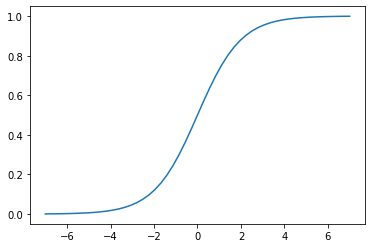

In [36]:
z = np.linspace(-7, 7, 51)
plt.plot(z, sigmoid(z))

It can be seen that the results of the sigmoid function are bounded between 0 and 1.

Below is the implementation of predict function for logistic regression:

In [37]:
def predict_logistic(x, w, b):
    linear_combination = np.dot(x, w) + b
    return sigmoid(linear_combination)


## Cost Function

Recall that for logistic regression, the cost function is of the form:

$$ J(\mathbf{w},b) = \frac{1}{m} \sum_{i=0}^{m-1} \left[ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right]$$

For a given example $(x^{(i)}, y^{(i)})$, the loss function $L(\mathbf{w}, b)$ can be written as:

$$L(\mathbf{w}, b) = \begin{cases} 
-\log(f_{\mathbf{w}, b}(x^{(i)})) & \text{if } y^{(i)} = 1, \\ 
-\log(1 - f_{\mathbf{w}, b}(x^{(i)})) & \text{if } y^{(i)} = 0. 
\end{cases}$$

Where:
- $f_{\mathbf{w}, b}(x^{(i)}) = \frac{1}{1 + e^{-(\mathbf{w}^T x^{(i)} + b)}}$ is the predicted probability from the sigmoid function.

This system expresses the loss as two distinct cases:
- When $y^{(i)} = 1$, the model is penalized based on how close the predicted probability $f_{\mathbf{w}, b}(x^{(i)})$ is to 1.
- When $y^{(i)} = 0$, the model is penalized based on how close the predicted probability $f_{\mathbf{w}, b}(x^{(i)})$ is to 0.

## Gradient Descent

Recall the gradient descent algorithm utilizes the gradient calculation:
$$\begin{align*}
&\text{repeat until convergence:} \; \lbrace \\
&  \; \; \;w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j}  \; & \text{for j := 0..n-1} \\ 
&  \; \; \;  \; \;b = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \\
&\rbrace
\end{align*}$$

Below is the gradient calculation formula fo logistic regression. It looks similarly to the linear regression case. Each iteration performs simultaneous updates on $w_j$ for all $j$, where
$$\begin{align*}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})
\end{align*}$$

* m is the number of training examples in the data set      
* $f_{\mathbf{w},b}(x^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target
* For a logistic regression model  
    $z = \mathbf{w} \cdot \mathbf{x} + b$  
    $f_{\mathbf{w},b}(x) = g(z)$  
    where $g(z)$ is the sigmoid function:  
    $g(z) = \frac{1}{1+e^{-z}}$   
    


Let's train a linear regression model using the university admission dataset, where the goal is to predict admission based on exam scores, leveraging the sklearn library.

In [47]:
df_exam = pd.read_csv('data/exam_scores_admission.csv')

In [48]:
X_exam_train, X_exam_val, y_exam_train, y_exam_val = train_test_split(df_exam.drop(columns='admitted'), df_exam['admitted'], random_state=42, train_size=0.7)

In [49]:
model = LogisticRegression()

model.fit(X_exam_train, y_exam_train)

LogisticRegression()

In [50]:
pred_train = model.predict(X_exam_train)
pred_val = model.predict(X_exam_val)

In [52]:
acc_train = accuracy_score(y_exam_train, pred_train)
acc_val = accuracy_score(y_exam_val, pred_val)

acc_train, acc_val

(0.8857142857142857, 0.8666666666666667)